In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

import os
import pandas as pd
import numpy as np
from torchvision.io import read_image

x1 = torch.arange(-15, 15, 0.1)
x2 = torch.arange(-15, 15, 0.1) / 5
x = torch.stack([x1, x2], dim=1)
y = x[:,0] * 2. + 0.2 * x[:, 1]**2 - 3 + torch.normal(0., 0.2, (1, 300))
df_t = torch.stack([x1, x2, y[0]], dim=1)

# Обернем все в pd.DataFrame
df = pd.DataFrame(df_t, columns=["x1", "x2", "y"])

In [2]:
class MyCustomDataset(Dataset):
    def __init__(self, dataframe, train):
        df_train, df_test  = train_test_split(dataframe, random_state=1)
        
        if (train):
            data = df_train
        else:
            data = df_test
        
        self.features = data.drop("y", axis=1)
        self.target = data[["y"]]

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        #features = self.features.iloc[idx]
        #target = self.target.iloc[idx]

        features = torch.tensor(self.features.iloc[idx].values)
        targets = torch.tensor(self.target.iloc[idx].values)

        return features, targets

In [3]:
train_data = MyCustomDataset(
    dataframe = df,
    train=True
)

test_data = MyCustomDataset(
    dataframe = df,
    train=False
)

train_dataloader = DataLoader(train_data, batch_size=5, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=5, shuffle=True)

train_features, train_labels = next(iter(test_dataloader))
print(train_features)
print("#"*50)
print(train_labels)

tensor([[10.1000,  2.0200],
        [-6.2000, -1.2400],
        [ 9.2000,  1.8400],
        [-0.3000, -0.0600],
        [13.2000,  2.6400]])
##################################################
tensor([[ 18.2410],
        [-14.9511],
        [ 16.3876],
        [ -3.3570],
        [ 24.8099]])


# Задание 2. Свертки и базовые слои 
Это задание будет являться духовным наследником первого. 
Вы уже научились делать шаги градиентного спуска и вспомнили, как устроен базовый линейный слой.
На этой неделе мы построим прототип базового фреймворка до конца (собственно, многое вы сможете скопировать, если захотите). 
Хоть вы уже и знаете о torch.nn, для выполнения задания его использовать нельзя. 
Однако все элементы, которые вы будете реализовывать, достаточно просты.

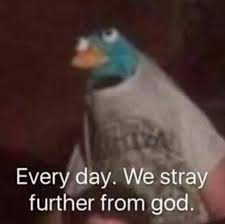

In [4]:
class Layer:
    def __init__(self):
        self.param = None
        self.train = None
    #def __repr__(self):
        # Функция, которая вызовется при print()
        
    def __call__(self, data):
        return data

class Model:
    def __init__(self):
        ''' Набиваем модель слоями. Исполнение идет с лева на право: X------> '''
        self.layers = [Layer(), Layer(), Layer(), Layer()]

    def __call__(self, data):
        return self.forward(data)

    def parameters(self):
        parameters_arr = []

        for i in range(len(self.layers)):
            parameters_arr.append(self.layers[i].param)
        
        return parameters_arr
    
    def train(self):
        for i in range(len(self.layers)):
            self.layers[i].train = True
    
    def eval(self):
        for i in range(len(self.layers)):
            self.layers[i].train = False
    
    def forward(self, data):
        for i in range(len(self.layers)):
            data = self.layers[i](data)
        return data

Используется стандартный метод градиентного спуска

In [5]:
class Optimizator:
    def __init__(self, model_parameters, lr=0.001):
        #self.model_parameters = model_parameters[::-1] # <- приводит к копированию 
        self.model_parameters = model_parameters
        self.lr = lr
    
    def zero_grad(self):
        # Тут мы сбрасывыем  градиенты в нуль 
        for i in range(len(self.model_parameters)):
            for j in range(len(self.model_parameters[i])):
                self.model_parameters[i][j].grad = None

    def step(self):
        # Тут мы коррентируем веса в соотвествии с SGD 
        for i in range(len(self.model_parameters)):
            for j in range(len(self.model_parameters[i])):
                grad = self.model_parameters[i][j].grad.data
                self.model_parameters[i][j].data = self.model_parameters[i][j].data - self.lr * grad

## Задача 1. (2 балла)
Реализуйте слой BatchNorm (nn.BatchNorm). 
[Идея для вдохновления как всегода нашлась на хабре](https://habr.com/ru/articles/309302/)

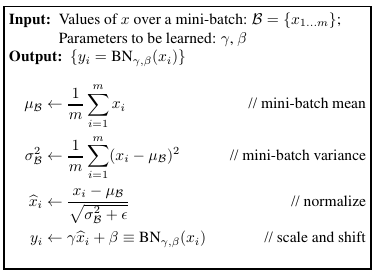

In [6]:
class BatchNorm(Layer):
    def __init__(self, len):
        self.w = torch.rand(len, requires_grad=True)
        self.b = torch.rand(len, requires_grad=True)
        self.param = [self.w, self.b]
    
    def __call__(self, data):
        mean = data.mean()
        variance = data.var()
        data_2 = (data - mean) / torch.sqrt(variance)

        return (data_2*self.w + self.b)

In [7]:
class MyModel(Model):
    def __init__(self):
        ''' Самая простая линейная модель '''
        self.layers = [BatchNorm(1)]

In [8]:
model = MyModel()
loss_fn = nn.MSELoss()

optimizer = Optimizator(model.parameters() , lr=1e-3)

/home/dima/Документы/Першин_Никольская_Нейронные_сети/.myvenv/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([1, 5, 1])) that is different to the input size (torch.Size([5, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


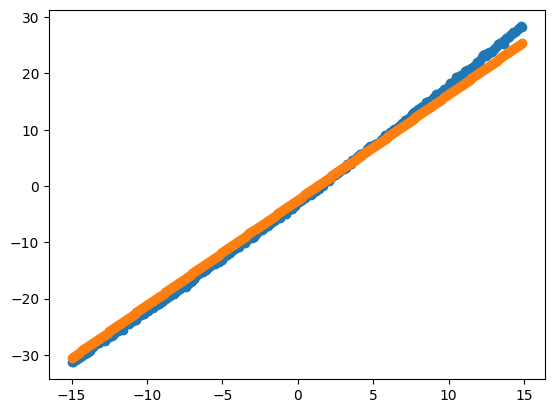

In [9]:
model.train()

for i in range(50):
    for batch_idx, (inputs, targets) in enumerate(train_dataloader):
        preds = model(inputs[:, 0:1])
        
        loss = loss_fn(preds, targets.unsqueeze(0))

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

preds = model(x[:, 0])

plt.scatter(x[:, 0], y)
plt.scatter(x[:, 0], preds.detach().numpy())


## Задача 2. (2 балла)
Реализуйте слой Linear (nn.Linear). 


In [10]:
class Linear(Layer):
    def __init__(self, input_len, output_len):
        self.W = torch.rand(input_len+1, output_len, requires_grad=True)
        self.param = [self.W]
    
    def __call__(self, data):
        
        X_1 = torch.ones(data.size()[0]).unsqueeze(1)
        X_con = torch.cat((X_1, data), 1)
        return (X_con @ self.W)

In [11]:
class MyModel(Model):
    def __init__(self):
        ''' Самая простая линейная модель '''
        self.layers = [Linear(2, 1)]

In [12]:
model = MyModel()
loss_fn = nn.MSELoss()

optimizer = Optimizator(model.parameters(), lr=1e-3)

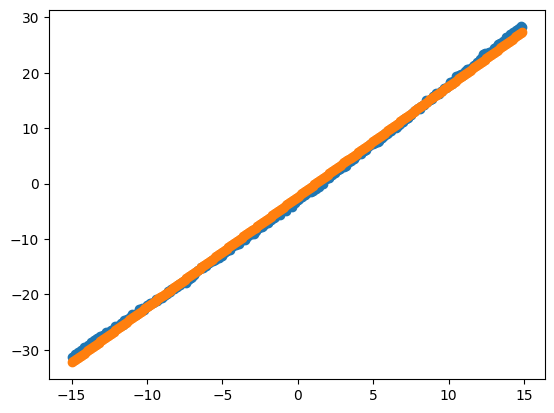

In [13]:
model.train()

for i in range(50):
    for batch_idx, (inputs, targets) in enumerate(train_dataloader):
        preds = model(inputs)
        
        loss = loss_fn(preds, targets.unsqueeze(0))

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

preds = model(x)

plt.scatter(x[:, 0], y)
plt.scatter(x[:, 0], preds.detach().numpy())

## Задача 3. (2 балла)
Реализуйте слой Dropout(nn.Dropout)

Снова идем на habr для изучения [материала](https://habr.com/ru/companies/wunderfund/articles/330814/)

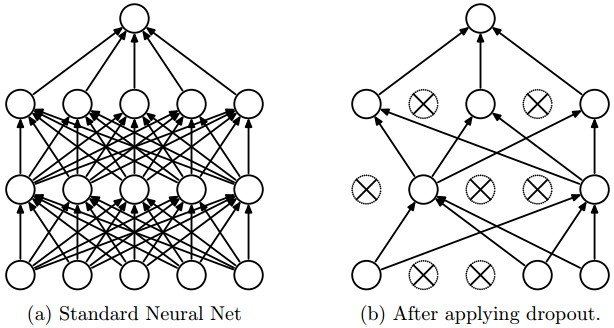

In [14]:
class Dropout(Layer):
    def __init__(self, prob=0.1):
        self.prob = prob
        self.param = []
    
    def __call__(self, data):
        self.D = torch.tensor(np.random.binomial(size=len(data), n=1, p=self.prob), dtype=torch.uint8)
        if (self.train):
            return torch.mul(data, self.D.unsqueeze(1))
        else:
            return torch.mul(data, self.prob)

In [15]:
class MyModel(Model):
    def __init__(self):
        ''' Самая простая линейная модель '''
        self.layers = [Dropout(0.5)]

In [16]:
model = MyModel()

model.train()

print(model(torch.tensor([[1], [1], [1], [1], [1]])))
print(model(torch.tensor([[1], [1], [1], [1], [1]])))
print(model(torch.tensor([[1], [1], [1], [1], [1]])))

model.eval()

print(model(torch.tensor([[1], [1], [1], [1], [1]])))

tensor([[1],
        [1],
        [1],
        [0],
        [0]])
tensor([[1],
        [1],
        [0],
        [0],
        [1]])
tensor([[0],
        [0],
        [1],
        [1],
        [0]])
tensor([[0.5000],
        [0.5000],
        [0.5000],
        [0.5000],
        [0.5000]])


## Задача 4. {*} (2 балла, 1 за каждый следующий за слой)
Реализуйте одно или более из:
  - слой ReLU(nn.ReLU)
  - слой Sigmoid(nn.Sigmoid)
  - слой Softmax(nn.Softmax)

Статья Habr: ["Выбор слоя активации в нейронных сетях: как правильно выбрать для вашей задачи"](https://habr.com/ru/articles/727506/)

In [17]:
class ReLU(Layer):
    def __init__(self):
        self.param = []
    
    def __call__(self, data):
        data[data < 0] = 0
        return data

In [18]:
class Sigmoid(Layer):
    def __init__(self):
        self.param = []
    
    def __call__(self, data):
        return torch.sigmoid(data)

In [19]:
class SoftMax(Layer):
    def __init__(self):
        self.param = []
    
    def __call__(self, data):
        return torch.softmax(data, dim=0)

In [20]:
class MyModel1(Model):
    def __init__(self):
        self.layers = [ReLU()]

class MyModel2(Model):
    def __init__(self):
        self.layers = [Sigmoid()]

class MyModel3(Model):
    def __init__(self):
        self.layers = [SoftMax()]

In [21]:
model1 = MyModel1()
model2 = MyModel2()
model3 = MyModel3()


print("ReLU:", model1(torch.tensor([[-0.32], [0.45], [1], [-100], [15]])).T.data.numpy()[0])
print("Sigmoid:", model2(torch.tensor([[-0.32], [0.45], [1], [-100], [15]])).T.data.numpy()[0])
print("SoftMax:", model3(torch.tensor([[-0.32], [0.45], [1], [-100], [15]])).T.data.numpy()[0])


ReLU: [ 0.    0.45  1.    0.   15.  ]
Sigmoid: [0.42067575 0.6106393  0.7310586  0.         0.99999964]
SoftMax: [2.2213040e-07 4.7974953e-07 8.3152742e-07 0.0000000e+00 9.9999845e-01]


## Задача 5. {*}. 
Вы получите по 1 дополнительному баллу за слой, 
если реализуете в рамках фреймворка из задания 3 прошлой работы


# Задание 2. {*} 3 балла
Реализуйте медианный фильтр. 
Для текущего пикселя, пиксели, которые «попадают» в матрицу, 
сортируются, и выбирается медианное значение из отсортированного массива. 
Это значение и является выходным для текущего пикселя.
Используйте только чистый torch. Покажите результат на примере для размера ядра 3, 5, 10

In [22]:
class MedianFilter(Layer):
    def __init__(self,
                 kernel_size, # Размер ядра
                 padding=1, # значение в пикселях, на который будет сдвинуто ядро на каждом следующем шаге
                 stride=0   # значение в пикселях, ширина "рамки", которая будет добавлена вокруг изображения
                 ):
        self.kernel_size = kernel_size
        self.padding = padding
        self.stride = stride
        self.param = []
    
    def __call__(self, data):
        dsize = data.size()
        ksize = self.kernel_size

        mylist = [torch.Tensor(list(dsize)),
                  torch.Tensor(ksize * -1),
                  torch.ones(len(list(dsize)))] # torch.ones(dims.size())
        result = torch.stack(mylist, dim=0).sum(dim=0).int()
        
        data_exit = torch.zeros(result.tolist())
        
        for i in range (data_exit.size()[0]):
            for j in range (data_exit.size()[1]):
                ii = i+ksize.tolist()[0]
                jj = j+ksize.tolist()[1]
                #print(i, ":", ii, ";", j, ":", jj)
                kdata = data[i:ii, j:jj]
                #print(kdata)
                median = torch.median(kdata)
                data_exit[i][j] = median
        
        return data_exit


In [23]:
class MyModel(Model):
    def __init__(self):
        self.layers = [MedianFilter(kernel_size=torch.tensor([3, 3], dtype=torch.int), padding=1, stride=0)]

#torch.manual_seed(0)

tensor_test = torch.rand([5, 5])
model = MyModel()

In [24]:
print(tensor_test)
model(tensor_test)

tensor([[0.5725, 0.3393, 0.9617, 0.0795, 0.6813],
        [0.3864, 0.3900, 0.7458, 0.7978, 0.0805],
        [0.1975, 0.6323, 0.6901, 0.5053, 0.8806],
        [0.3872, 0.9190, 0.6441, 0.3165, 0.7208],
        [0.9400, 0.9882, 0.7639, 0.5395, 0.8178]])


tensor([[0.5725, 0.6323, 0.6901],
        [0.6323, 0.6441, 0.6901],
        [0.6901, 0.6441, 0.6901]])


# Задание 3. 6 баллов
Реализуйте следующие классы (указана сигнатура __init__):
- BaseTransform(p: float) [*базовый класс для всех трансформаций*]
- RandomCrop(p: float, **kwargs)
- RandomRotate(p: float, **kwargs)
- RandomZoom(p: float, **kwargs) {*}
- ToTensor() 
- Compose(list[BaseTransform])

Последний класс должен принимать на вход список инстансов трех других.
При вызове метода __call__ он должен последовательно вызывать трансформации из списка.
При вызове каждого из них с вероятностью p должно 
применяться изменение изображения, с вероятностью 1-p должно возвращаться исходное 
изображение. Класс входного изображения у всех классов - PIL.Image, выходного тоже.
Класс ToTensor должен принимать на вход PIL.Image, возвращать - torch.Tensor.

**torch.nn использовать нельзя!**

{*} (1 балл) Протестируйте ваши классы на воспроизводимость, результат, граничные случаи.

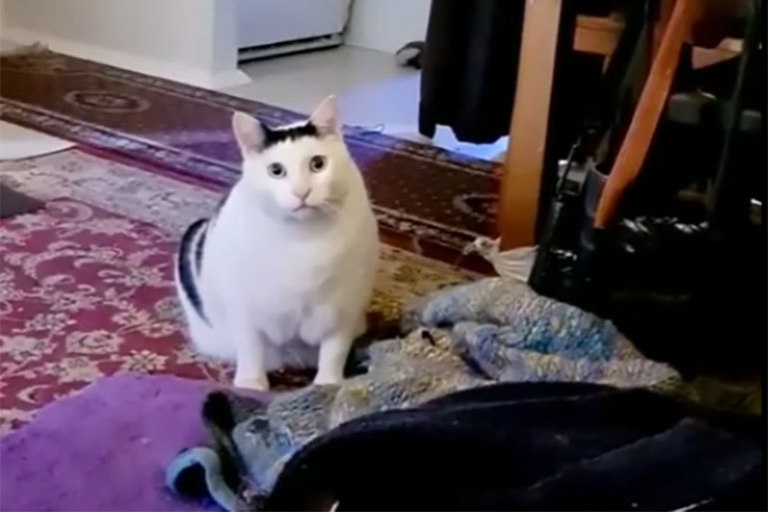

In [25]:
from pathlib import Path
import torch
import matplotlib.pyplot as plt
#plt.rcParams["savefig.bbox"] = 'tight'

from torchvision.transforms import v2
from torchvision.io import decode_image
import torchvision.transforms.functional as transform

import torch
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt

#torch.manual_seed(1)

#img = decode_image('../../additional_materials/images/astronaut.jpg')
import PIL

img = Image.open('../../additional_materials/images/kot_mjaukaet.jpg')

#img = np.asarray(img)

display(img)

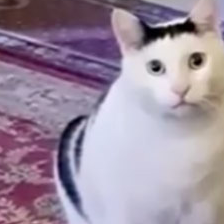

In [26]:
transform = v2.RandomCrop(size=(224, 224))
out = transform(img)
display(out)

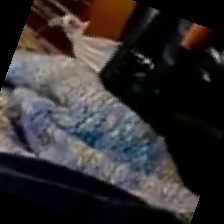

In [27]:
transforms = v2.Compose([
    v2.RandomCrop(size=(224, 224)),
    v2.RandomRotation(degrees=45),
#    v2.RandomZoomOut()
])

out = transforms(img)
display(out)

## BaseTransform(p: float) [*базовый класс для всех трансформаций*]


In [28]:
class BaseTransform:
    def __init__(self, prob = 0.5):
        self.prob = prob
    
    def __call__(self, data:PIL.Image):
        return data

## Compose(list[BaseTransform])

In [29]:
class Compose(BaseTransform):
    def __init__(self, list_transform:list[BaseTransform]):
        self.transforms = list_transform
    def __call__(self, data:PIL.Image):
        for transform in self.transforms:
            data = transform(data)
        return data

## RandomRotation(p: float, **kwargs)

In [30]:
import PIL.Image
from scipy.stats import bernoulli


class RandomRotation(BaseTransform):
    def __call__(self, data:PIL.Image):
        prob = bernoulli.rvs(size=1, p=self.prob)
        if (prob):
            data = data.rotate(np.random.randint(0, 360, 1) )
        return data

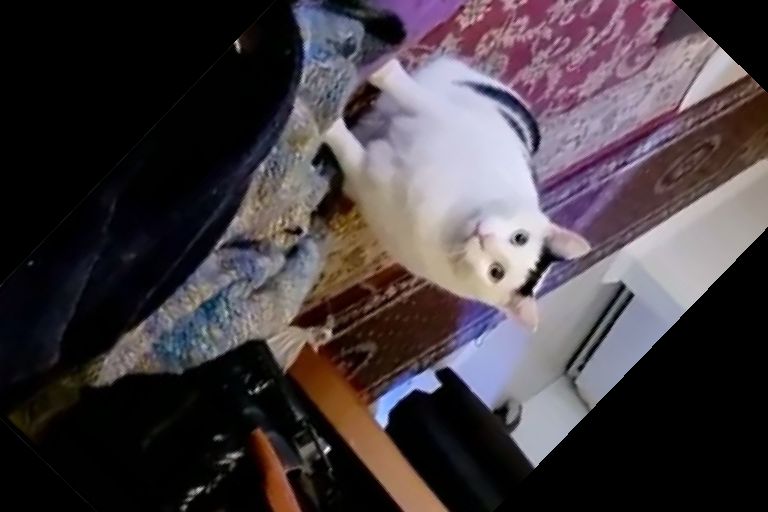

(768, 512)

In [31]:
my_transformer = Compose([
    RandomRotation(),
])

out = my_transformer(img)
display(out)
out.size

## RandomCrop(p: float, **kwargs)


In [32]:
from scipy.ndimage import zoom


class RandomCrop(BaseTransform):
    def __init__(self, prob = 0.5, size=[224, 224]): #, crop_factor_range = [1, 10]):
        self.prob = prob
        self.crop_size = size

    def __call__(self, img:PIL.Image):
        prob = bernoulli.rvs(size=1, p=self.prob)
        
        if (prob):
            img_size = img.size

            start_point = [np.random.randint(0, img_size[0] - self.crop_size[0], 1)[0], 
                           np.random.randint(0, img_size[1] - self.crop_size[1], 1)[0]]

            region = start_point + start_point
            region[2] += self.crop_size[0]
            region[3] += self.crop_size[1]

            img = img.crop(region)
        return img

class ReSize(BaseTransform):
    def __init__(self, size=[224, 224]):
        self.new_size = size

    def __call__(self, img:PIL.Image):
        img = img.resize(self.new_size, Image.Resampling.LANCZOS)
        return img

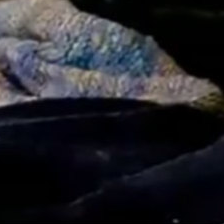

In [33]:
my_transformer = Compose([
    RandomCrop(prob=0.5, size=[224, 224]),
    ReSize(size=[224, 224]),
])

out = my_transformer(img)
display(out)

## RandomZoom(p: float, **kwargs) {*}

In [34]:
class RandomZoom(BaseTransform):
    def __init__(self, prob = 0.5 , scale_factor_range = [0.3, 10]):
        self.prob = prob
        self.scale_factor_range = scale_factor_range

    def __call__(self, img:PIL.Image):
        prob = bernoulli.rvs(size=1, p=self.prob)
        if (self.scale_factor_range[0] < 1 and self.scale_factor_range[1] > 1):
            decrease = bernoulli.rvs(size=1, p=0.5)
        elif (self.scale_factor_range[0] < 1):
            decrease = True
        else:
            decrease = False


        if (prob):
            img_size = img.size
            
            if (not(decrease)):
                crop_level = np.random.randint(11, int(self.scale_factor_range[1]*10), 1) / 10.0
                crop_size = img_size // crop_level

                
                start_point = [np.random.randint(0, img_size[0] - crop_size[0], 1)[0], 
                               np.random.randint(0, img_size[1] - crop_size[1], 1)[0]]

                end_point = start_point + crop_size

                region = start_point
                region[2:3] = end_point

                # cropping a region from the image and storing it as cropped_img
                img = img.crop(region)

                img = img.resize(img_size, Image.Resampling.LANCZOS)
                return img
            else:
                crop_level = np.random.randint(int(self.scale_factor_range[0]*100), 90, 1) / 100.0
                #print(crop_level)
                crop_size = img_size // crop_level
                #print(crop_size)

                
                center_image_coord = (crop_size - img_size) // 2
                #print(center_image_coord)
                #print(np.array(img).size)
                if not(type(np.array(img).size) == int):
                    big_img = Image.new('RGB', list(crop_size.astype(int)), color = 'black')
                else:
                    big_img = Image.new('L', list(crop_size.astype(int)), color = 'black')
                #print(np.array(big_img).size)

                # This is the region where the cropped image is to be pasted
                
                region_3 = np.array([center_image_coord, center_image_coord + img_size])
                region_3 = region_3.reshape(-1).astype(int)
                #print(region_3)
                
                # pasting the cropped region to the image itself
                #print(img_size)
                #display(img)

                big_img.paste(img, region_3)
                big_img = big_img.resize(img_size, Image.Resampling.LANCZOS)
                return big_img
                #display(img)
                #print(img[0][0])
                #img = #big_img
        return img

(768, 512)


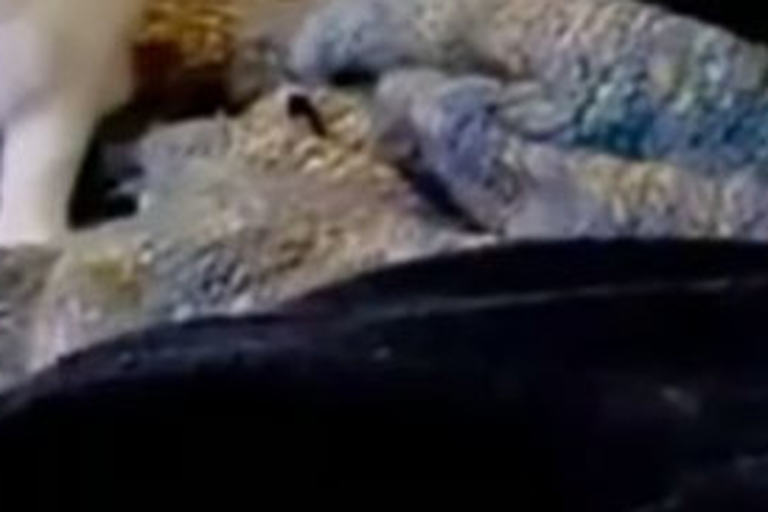

In [35]:
my_transformer = Compose([
    RandomZoom(scale_factor_range=[0.2, 5], prob=1),
])

out = my_transformer(img)
print(out.size)
display(out)

## ToTensor() 

In [36]:
class ToTensor(BaseTransform):
    def __init__(self):
        pass
    
    def __call__(self, img:PIL.Image):
        img = np.array(img)
        #print(img.shape)
        img = torch.tensor([img], dtype=torch.float)
        #print(img.size())
        return img

## ToPILImage()


In [37]:
import torchvision.transforms as T

class ToPILImage(BaseTransform):
    def __init__(self):
        pass
    
    def __call__(self, img):
        transform = T.ToPILImage()
        #print("DISP IMG:")
        #display(transform(image))
        image = transform(img)
        return image

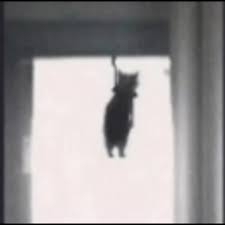

/tmp/ipykernel_18876/1619633584.py:8: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  img = torch.tensor([img], dtype=torch.float)


In [38]:
img = Image.open('../../additional_materials/images/cat_suicide.jpeg')
display(img)

my_transformer = Compose([ ToTensor() ])

tensor_cat = my_transformer(img)

#display(tensor_cat)

# Задание 4. 3 балла
Примените трансформации из задания 3 в качестве трансформаций датасета из практики 2.2.
**В этом задании можно пользоваться torch.nn, за исключением трансформаций.**
Покажите, как меняются лосс и метрики на трейне и на тесте в зависимости от количества и вероятностей трансформаций.
Проведите обучение на большом количестве эпох. 
Опишите, что вы наблюдаете для каждого случая и какая есть разница,
если применить трансформации.
Предоставьте графики в matplotlib или tensorboard (+1 балл) в 
ноутбуке (в случае с tensorboard можно в отдельном окне) с наглядными примерами

In [39]:
#from torchvision.transforms import ToTensor
import torchvision

In [40]:
from torchvision.datasets.mnist import read_image_file, read_label_file

class FashionMNISTDataset(Dataset):
    def __init__(self, file_dir, train=True, transform=None, target_transform=None):
        self.transform = transform
        self.target_transform = target_transform
        self.train = train
        image_file = f"{'train' if self.train else 't10k'}-images-idx3-ubyte"
        self.data = read_image_file(os.path.join(file_dir, image_file))

        label_file = f"{'train' if self.train else 't10k'}-labels-idx1-ubyte"
        self.targets = read_label_file(os.path.join(file_dir, label_file))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = self.data[idx]
        
        label = self.targets[idx]
        
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [41]:
train_data = FashionMNISTDataset(
    file_dir="../../datasets/FashionMNIST/raw/",
    train=True,
    transform=Compose([
            ToPILImage(),
            RandomZoom(scale_factor_range=[0.8, 1.2], prob=0.5),
            #RandomCrop(p: float, **kwargs)
            RandomRotation(prob=0.5),
            ToTensor()
        ]),
)

test_data = FashionMNISTDataset(
    file_dir="../../datasets/FashionMNIST/raw/",
    train=False,
    #transform=torchvision.transforms.ToTensor(),
)

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")


train_dataloader = DataLoader(train_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

Using cpu device


Feature batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64])


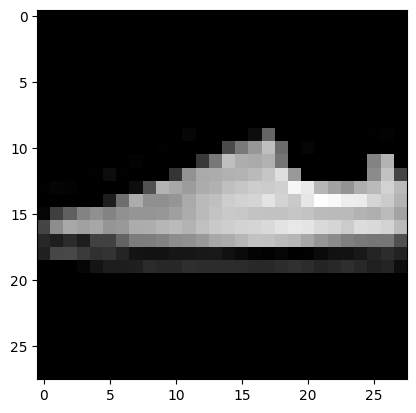

Label: 7


In [42]:
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze().reshape(28,28)
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

In [43]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.base = nn.Sequential(
            # your code
            nn.Conv2d(1, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 16, 3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU()

        )
        self.head = nn.Linear(16*28*28, 10)

    def forward(self, x):
        x = self.base(x)
        # Необходимо превратить вход в вектор, чтобы можно было применить линейный слой

        x = x.view(x.size(0), -1)
        logits = self.head(x)
        return logits

model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (base): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
  )
  (head): Linear(in_features=12544, out_features=10, bias=True)
)


In [44]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In [45]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch_idx, (inputs, targets) in enumerate(dataloader):
        inputs, targets = inputs.to(device), targets.to(device)

        # Compute prediction error
        preds = model(inputs)
        loss = loss_fn(preds, targets)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_idx % 100 == 0:
            loss, current = loss.item(), (batch_idx + 1) * len(inputs)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            
        ''' Чтобы сделать задание со сравнением лоссов, не забудьте 
            реализовать трекинг минимального лосса  '''

In [46]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, num_correct = 0, 0
    with torch.no_grad():
        for inputs, targets in dataloader:
            # your code
            preds = model(inputs)
            test_loss += loss_fn(preds, targets)
            preds_classes = torch.argmax(preds, dim=-1)
            
            num_correct += (preds_classes.squeeze() == targets.squeeze()).sum().item()
    
    test_loss /= num_batches
    num_correct /= size
    print(f"Test Error: \n Accuracy: {(100*num_correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return 100*num_correct, test_loss
    ''' Чтобы сделать задание со сравнением лоссов, не забудьте 
            реализовать трекинг минимального лосса  '''

In [47]:
epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    acc, loss = test(train_dataloader, model, loss_fn)
    
    # вызовите функции обучения и валидации

Epoch 1
-------------------------------
loss: 2.433380  [   64/60000]
loss: 1.692045  [ 6464/60000]
loss: 1.479665  [12864/60000]
loss: 1.236092  [19264/60000]


KeyboardInterrupt: 


# Задание 5. {*}  4 балла
Настройте проект в weights and biases, настройте логгинг туда из вашего цикла обучения (задание 4).
Выводите лосс и метрики на трейне и на тесте. Графики из задания 4 в таком случае можно выводить только туда.
Можете сохранять параметры обучения в качестве констант, и смотреть на сводную таблицу.


In [ ]:
#%pip install weave


In [ ]:
'''import wandb
import random

# start a new wandb run to track this script
wandb.init(
    # set the wandb project where this run will be logged
    project="my-awesome-project",

    # track hyperparameters and run metadata
    config={
    "learning_rate": 0.02,
    "architecture": "CNN",
    "dataset": "CIFAR-100",
    "epochs": 10,
    }
)

# simulate training
epochs = 10
offset = random.random() / 5
for epoch in range(2, epochs):
    acc = 1 - 2 ** -epoch - random.random() / epoch - offset
    loss = 2 ** -epoch + random.random() / epoch + offset

    # log metrics to wandb
    wandb.log({"acc": acc, "loss": loss})

# [optional] finish the wandb run, necessary in notebooks
wandb.finish()
'''

In [48]:
import wandb
import random

# start a new wandb run to track this script
wandb.init(
    # set the wandb project where this run will be logged
    project="my-awesome-project",

    # track hyperparameters and run metadata
    config={
    "learning_rate": 0.02,
    "architecture": "CNN",
    "dataset": "CIFAR-100",
    "epochs": 3,
    }
)

# simulate training
epochs = 3
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    acc, loss = test(train_dataloader, model, loss_fn)

    # log metrics to wandb
    wandb.log({"acc": acc, "loss": loss})

# [optional] finish the wandb run, necessary in notebooks
wandb.finish()


wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin


Epoch 1
-------------------------------
loss: 1.258131  [   64/60000]
loss: 1.239818  [ 6464/60000]
loss: 1.104649  [12864/60000]
loss: 1.153487  [19264/60000]
loss: 1.149825  [25664/60000]
loss: 1.205097  [32064/60000]
loss: 1.137471  [38464/60000]
loss: 1.083944  [44864/60000]
loss: 1.105942  [51264/60000]
loss: 1.137666  [57664/60000]
Test Error: 
 Accuracy: 63.3%, Avg loss: 1.044502 

Epoch 2
-------------------------------
loss: 1.073496  [   64/60000]
loss: 1.144920  [ 6464/60000]
loss: 0.885298  [12864/60000]
loss: 1.015554  [19264/60000]
loss: 1.036824  [25664/60000]
loss: 1.040294  [32064/60000]
loss: 0.981360  [38464/60000]
loss: 0.986447  [44864/60000]
loss: 1.023932  [51264/60000]
loss: 1.161575  [57664/60000]
Test Error: 
 Accuracy: 66.0%, Avg loss: 0.961598 

Epoch 3
-------------------------------
loss: 0.890378  [   64/60000]
loss: 0.760894  [ 6464/60000]
loss: 0.911322  [12864/60000]
loss: 0.965762  [19264/60000]
loss: 1.243368  [25664/60000]
loss: 0.845999  [32064/600

acc,▁▅█
loss,█▄▁
acc,68.36167
loss,0.90864


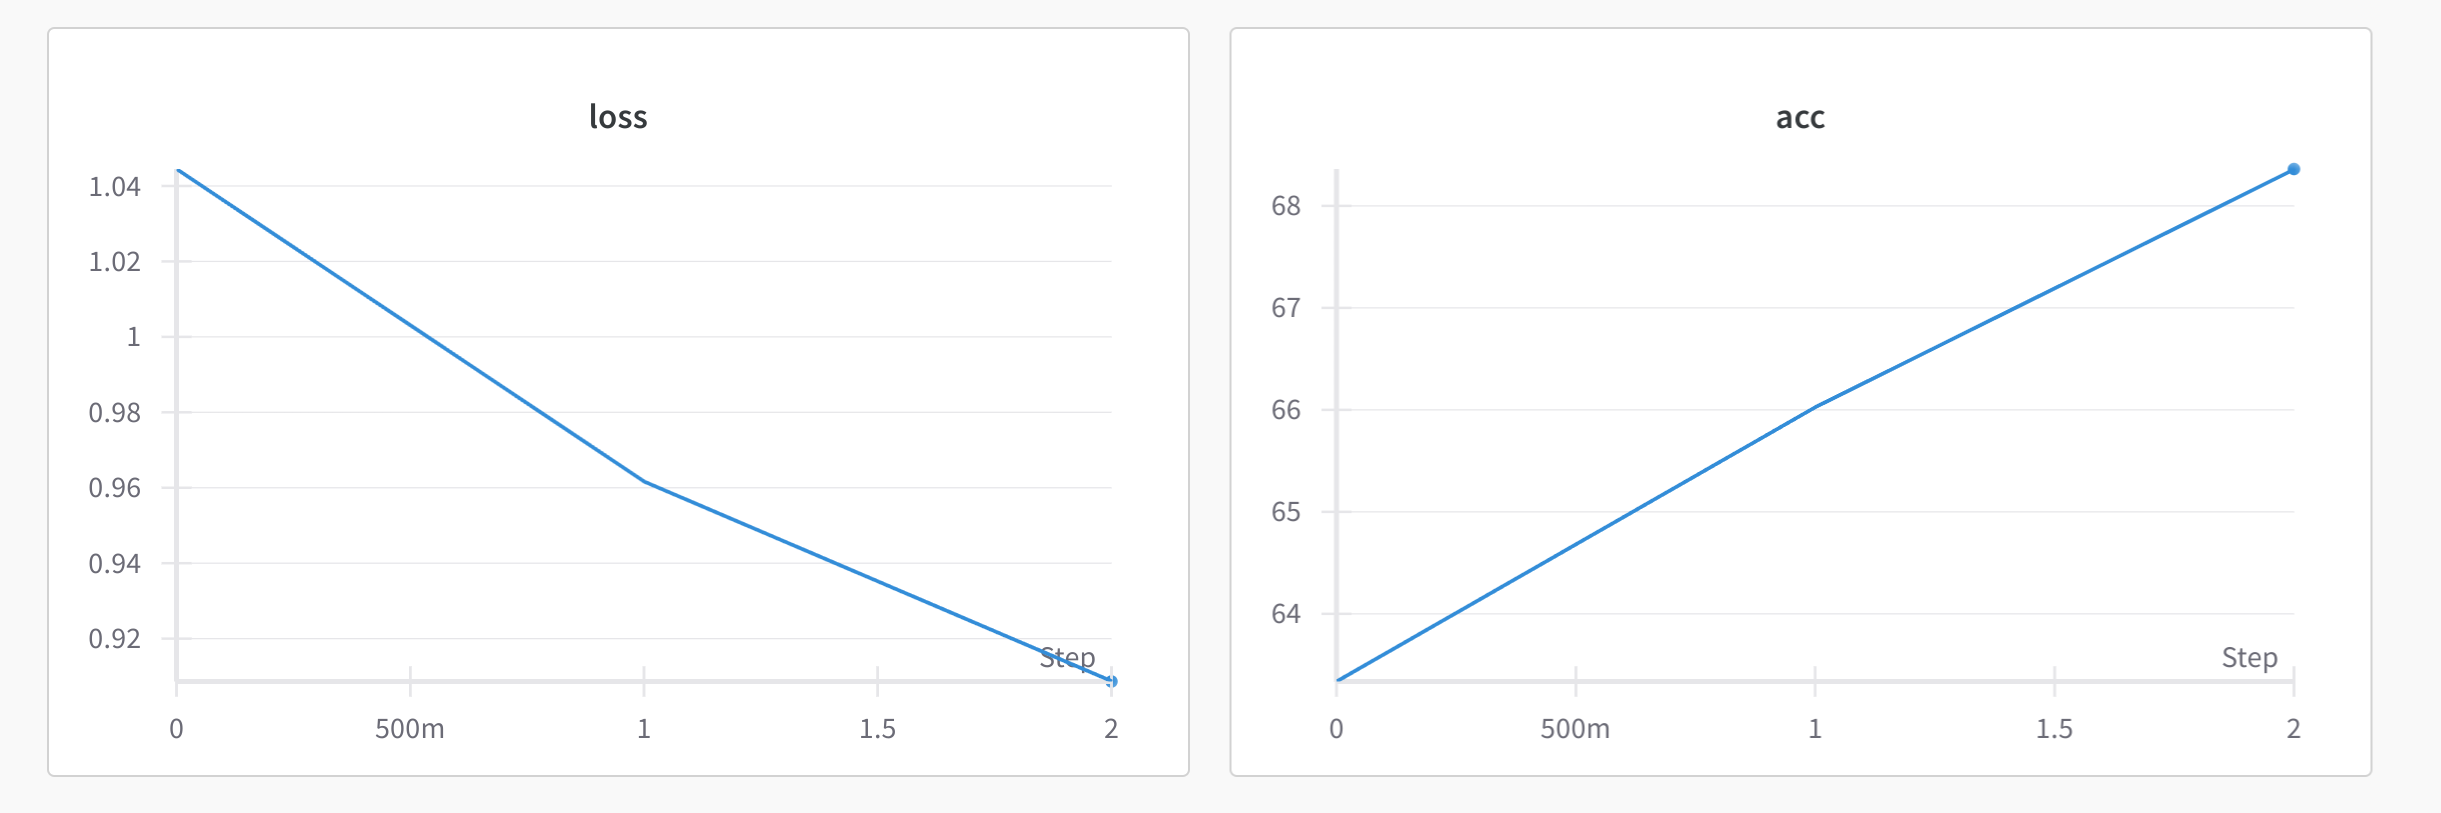